In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU
Total GPU Memory: 4.3 GB


In [3]:
filtered_dir = r'F:\Project\GPU\CV\brain2_filtered'

transform = transforms.Compose([
    transforms.Resize((32, 32)),                    # LeNet works best with 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(filtered_dir, 'Training'), transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(filtered_dir, 'Testing'),  transform=transform)

class_names = train_dataset.classes

print(f"Classes: {class_names}")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples:  {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training samples: 5712
Testing samples:  1311


In [4]:
class LeNet(nn.Module):
    def __init__(self, num_classes=4):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)   # 3 channels for RGB
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1   = nn.Linear(16 * 5 * 5, 120)      # After two maxpool(2): 32 → 14 → 5
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet(num_classes=4).to(device)
print("LeNet model loaded on GPU")
print(model)

LeNet model loaded on GPU
LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Often works well for LeNet

scaler = GradScaler()  # Enables faster training with mixed precision on GPU

print("Loss, optimizer, and scaler ready")

Loss, optimizer, and scaler ready


C:\Users\adity\AppData\Local\Temp\ipykernel_3232\367650977.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Enables faster training with mixed precision on GPU


In [6]:
num_epochs = 30  # LeNet usually needs more epochs than modern models

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with autocast():  # Mixed precision
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc  = 100. * correct / total
    print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_acc:.2f}%")


Epoch 1/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

C:\Users\adity\AppData\Local\Temp\ipykernel_3232\3434801336.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision


Train Loss: 0.8579 | Train Accuracy: 65.67%

Epoch 2/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.5249 | Train Accuracy: 79.88%

Epoch 3/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.4282 | Train Accuracy: 84.21%

Epoch 4/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.3555 | Train Accuracy: 86.76%

Epoch 5/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.2886 | Train Accuracy: 89.58%

Epoch 6/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.2440 | Train Accuracy: 90.84%

Epoch 7/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1984 | Train Accuracy: 93.10%

Epoch 8/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1572 | Train Accuracy: 94.70%

Epoch 9/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1394 | Train Accuracy: 94.84%

Epoch 10/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.1241 | Train Accuracy: 95.41%

Epoch 11/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0948 | Train Accuracy: 96.57%

Epoch 12/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0893 | Train Accuracy: 96.92%

Epoch 13/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0650 | Train Accuracy: 97.97%

Epoch 14/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0588 | Train Accuracy: 97.90%

Epoch 15/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0566 | Train Accuracy: 98.11%

Epoch 16/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0443 | Train Accuracy: 98.46%

Epoch 17/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0247 | Train Accuracy: 99.21%

Epoch 18/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0399 | Train Accuracy: 98.53%

Epoch 19/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0464 | Train Accuracy: 98.37%

Epoch 20/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0159 | Train Accuracy: 99.53%

Epoch 21/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0190 | Train Accuracy: 99.33%

Epoch 22/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0343 | Train Accuracy: 98.91%

Epoch 23/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0332 | Train Accuracy: 98.86%

Epoch 24/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0403 | Train Accuracy: 98.76%

Epoch 25/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0288 | Train Accuracy: 98.91%

Epoch 26/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0181 | Train Accuracy: 99.39%

Epoch 27/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0027 | Train Accuracy: 99.95%

Epoch 28/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0088 | Train Accuracy: 99.65%

Epoch 29/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0191 | Train Accuracy: 99.49%

Epoch 30/30


Training:   0%|          | 0/179 [00:00<?, ?it/s]

Train Loss: 0.0017 | Train Accuracy: 99.98%


In [7]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating Test Set"):
        images, labels = images.to(device), labels.to(device)
        with autocast():
            outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = 100. * correct / total
print(f"\nFinal Test Accuracy: {test_accuracy:.2f}%")

Evaluating Test Set:   0%|          | 0/41 [00:00<?, ?it/s]

C:\Users\adity\AppData\Local\Temp\ipykernel_3232\748190674.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Final Test Accuracy: 95.88%


In [8]:
save_path = r'F:\Project\GPU\CV\brain2_lenet_trained.pth'
torch.save(model.state_dict(), save_path)
print(f"Model successfully saved to:\n{save_path}")

Model successfully saved to:
F:\Project\GPU\CV\brain2_lenet_trained.pth


In [10]:
# Run this after training and evaluation to collect predictions

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Collecting Test Predictions"):
        images, labels = images.to(device), labels.to(device)
        with autocast():
            outputs = model(images)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Prediction collection complete.")

C:\Users\adity\AppData\Local\Temp\ipykernel_3232\1888744984.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Prediction collection complete.


<Figure size 800x600 with 0 Axes>

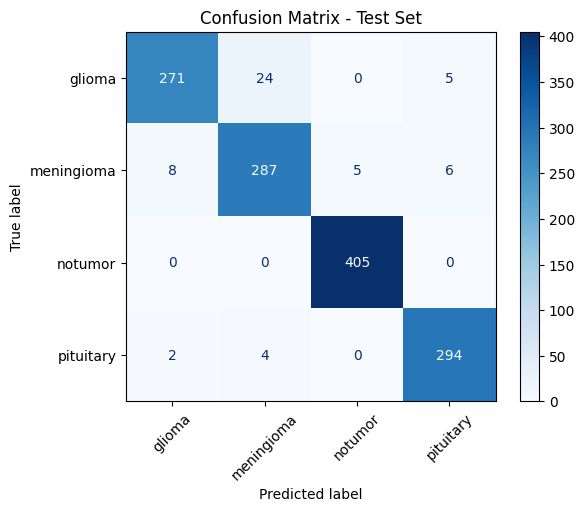

In [11]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Test Set')
plt.xticks(rotation=45)
plt.show()

C:\Users\adity\AppData\Local\Temp\ipykernel_3232\2183738799.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


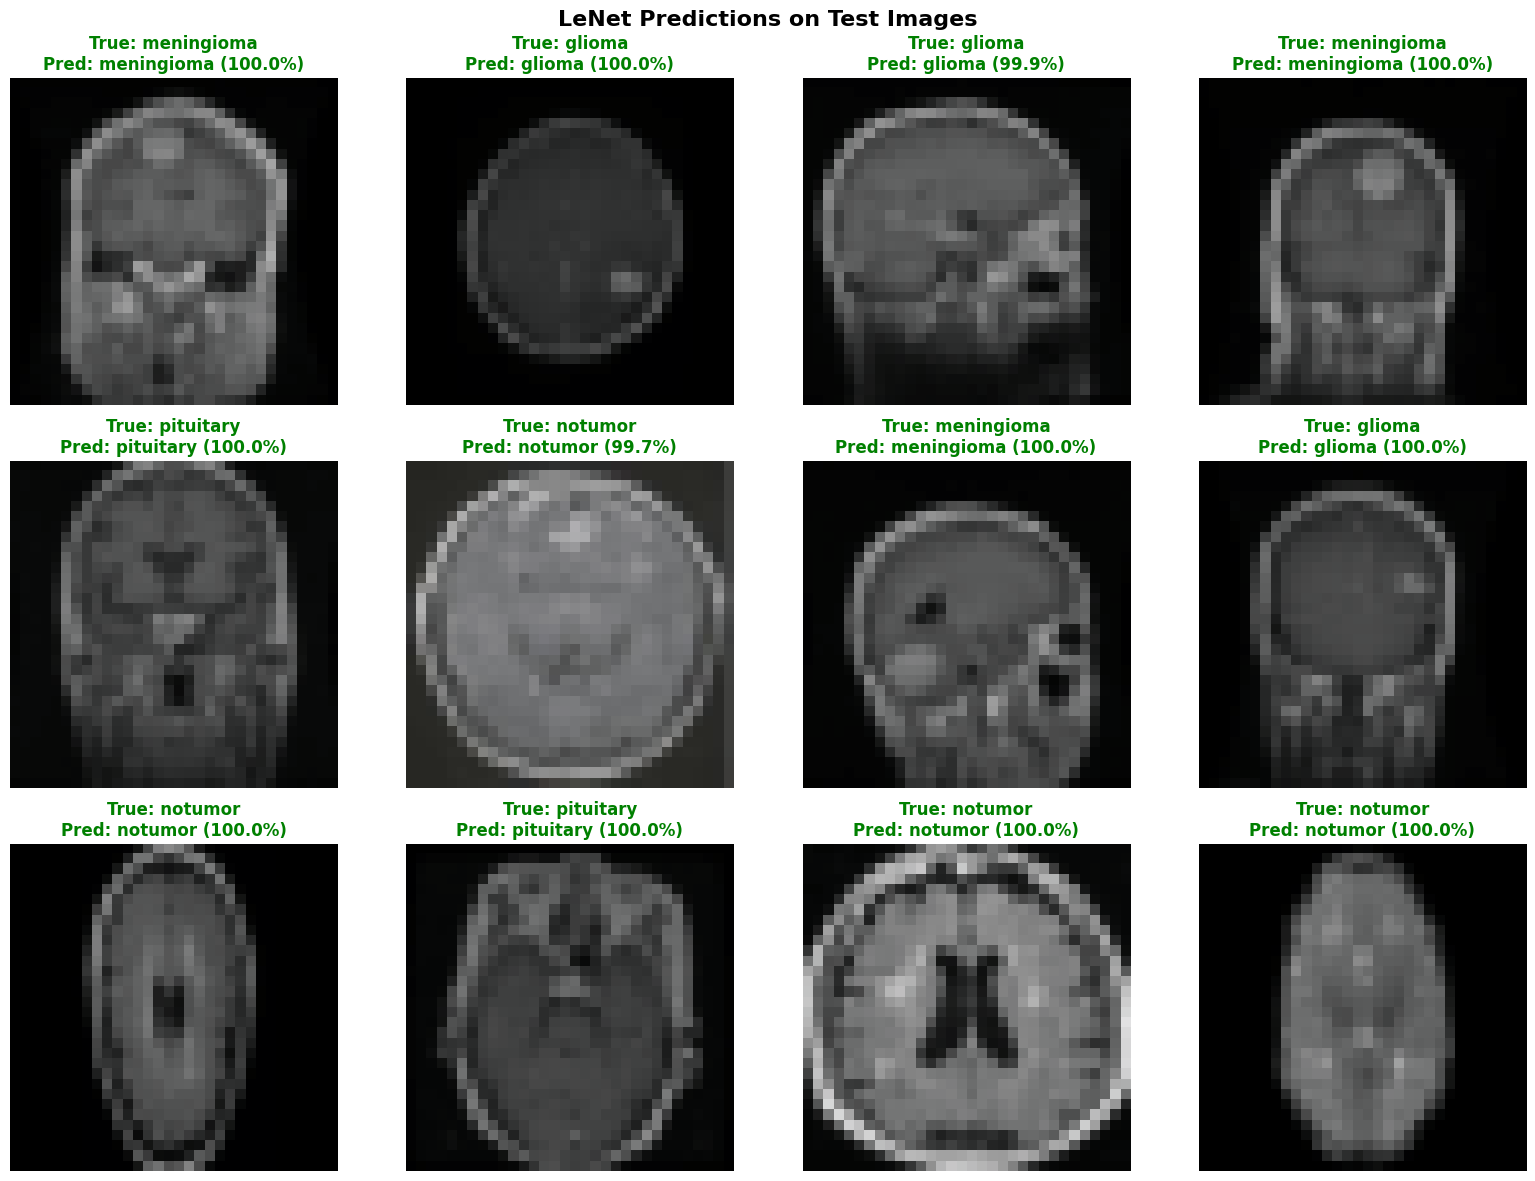

In [12]:
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split

# Get a random subset of the test dataset
num_samples = 12
subset_indices = random.sample(range(len(test_dataset)), num_samples)
subset_dataset = torch.utils.data.Subset(test_dataset, subset_indices)

subset_loader = DataLoader(subset_dataset, batch_size=num_samples, shuffle=False)

model.eval()
images, labels = next(iter(subset_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    with autocast():
        outputs = model(images)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    _, predicted = torch.max(outputs, 1)

# Move to CPU for plotting
images = images.cpu()
labels = labels.cpu()
predicted = predicted.cpu()
probabilities = probabilities.cpu()

# Denormalize images for display
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = images.numpy()
images = np.transpose(images, (0, 2, 3, 1))  # NCHW -> NHWC
images = std * images + mean
images = np.clip(images, 0, 1)

# Plot
cols = 4
rows = 3
plt.figure(figsize=(16, 12))

for i in range(num_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i])
    true_label = class_names[labels[i]]
    pred_label = class_names[predicted[i]]
    confidence = 100 * probabilities[i][predicted[i]].item()
    title = f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)"
    color = 'green' if predicted[i] == labels[i] else 'red'
    plt.title(title, color=color, fontsize=12, fontweight='bold')
    plt.axis('off')

plt.suptitle('LeNet Predictions on Test Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()